## Кредитный Скоринг

https://www.kaggle.com/c/fintech-credit-scoring

**В качестве итоговой модели был выбран Грдиентный бустинг, оценка roc-auc на тесте kaggle составила: 0.71614**

#### Описание задачи
Дана выборка заявок на кредитный продукт. Про заявителей известны различные данные на момент заполнения анкеты. По части выборки (train, validate) известны результаты пользования кредитом (случился дефолт или нет), а по другой части(test) результаты известны только организаторам. Необходимо извлечь зависимость из имеющихся данных о заявителях и фактом наличия дефолта, и предсказать результат на тестовых данных.
В качестве метрики используется AUC

## Оглавление:<a class='anchor' id='0'></a>
1. [Предобработка данных:](#1)
2. [Разбивка и подготовка данных](#2)
3. [Создание конвеера и обучение моделей](#3)
4. [Добавление полиномов и подбор параметров по сетке](#4)
5. [Сравнение ROC кривых](#5)
6. [Получение прогнозов](#6)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn
from sklearn.utils import shuffle
from matplotlib import pylab as plt
%matplotlib inline

### 1. Предобработка данных <a class='anchor' id='1'></a>
[в начало](#0)

**Подгрузка данных**

In [2]:
data = pd.read_csv('application_info.csv') # подрузим выборки
label = pd.read_csv('default_flg.csv') # подргузим целевые метки

In [3]:
# data.head() # выборки

In [4]:
# label.head() # целевые метки

**Описание признаков:**
- id - Анонимизированный идентификатор заявителя
- application_dt - Дата подачи заявки
- sample_cd - Категория выборки
- education_cd - Образование
- gender_cd - Пол
- age - Возраст
- car_own_flg - Флаг наличия автомобиля
- car_type_flg - Флаг наличия иномарки
- appl_rej_cnt - Количество отказанных прошлых заявок
- good_work_flg - Флаг наличия "хорошей" работы
- Score_bki - Скор балл по данным из бюро кредитных историй
- out_request_cnt - Количество запросов в бюро
- region_rating - Рейтинг региона
- home_address_cd - Категоризатор домашнего адреса
- work_address_cd - Категоризатор рабочего адреса
- income - Доход заявителя
- SNA - Связь заявителя с клиентами
- first_time_cd - Давность наличия информации о заявителе
- Air_flg - Наличие загран паспорта
- default_flg - Флаг дефолта по кредиту

Сразу удалю лишние данные в таблице (sample_cd и id)

In [5]:
# data[:110148] # train
# data[110148:180816] # validate
# data[180816:] # test

In [6]:
data.drop('sample_cd', axis=1, inplace=True)
data.drop('id', axis=1, inplace=True)

**Типы полей (признаков)**

In [7]:
# data.dtypes

**Несбалансированность классов**

In [8]:
label.default_flg.value_counts()

0    159982
1     20834
Name: default_flg, dtype: int64

Присутствует несбалансированность классов -> Будем учитывать это при построении моделей (class_weight='balanced')

**Исследуем поля на пропуски**

In [9]:
# data.isnull().sum()

Признак education_cd (образование) имеет пропуски. Проверим возможные значения данного признака и будем думать на что заменим пропуски.

In [10]:
data.education_cd.value_counts() # возможные значения признака education_cd (образование)

SCH    100234
GRD     71417
UGR     28284
PGR      3841
ACD       608
Name: education_cd, dtype: int64

In [11]:
# заменим пропуски в данном поле на 'NaN' (не указано)
data.fillna('NAN', inplace=True)

In [12]:
data.education_cd.value_counts()

SCH    100234
GRD     71417
UGR     28284
PGR      3841
NAN       912
ACD       608
Name: education_cd, dtype: int64

In [13]:
# data.isnull().sum()

**Анализ признаков на нормальность**

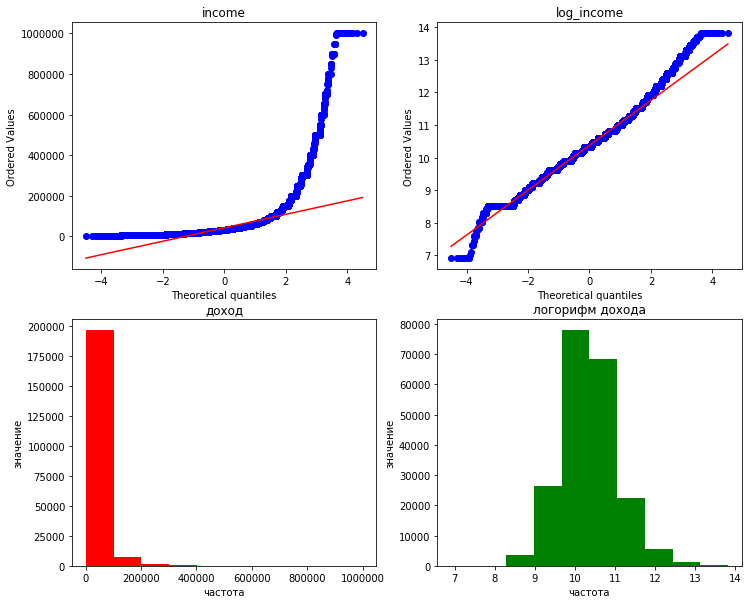

In [15]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
stats.probplot(data.income, dist="norm", plot=plt) # Q-Q график для income 
plt.title('income')
plt.subplot(2,2,2)
stats.probplot(np.log(data.income), dist="norm", plot=plt) # Q-Q график для age
plt.title('log_income')
plt.subplot(2,2,3)
plt.hist(data.income, color='red')
plt.title('доход')
plt.xlabel('частота')
plt.ylabel('значение')
plt.subplot(2,2,4)
plt.hist(np.log(data.income), color='green')
plt.title('логорифм дохода')
plt.xlabel('частота')
plt.ylabel('значение')
plt.show()

Q-Q график показывает, что логорифмирование признака income позволяет получить нормальное распределение.
Критерий Шапира-Уилка опустил в силу большой выборки (он работает на данных не превышающийх 5000 наблюдений)

Изменим данный признак на логарифм от income:

In [16]:
data['log_income'] = data.income.apply(lambda x: np.log(x)) # добавим признак log_income (логарифм дохода)
data.drop('income', axis=1, inplace=True) # удалим признак income (Доход)

**Обработка категориальных признаков**

Признак application_dt (Дата подачи заявки) разделим на 2 признака: день месяца, месяц. Год вообще нет смысла рассматривать в силу того, что обучающая выборка заканчивается в конце 2014 года, а тестовая начинается только с 1 января 2015. Подобное разбиение может помочь в обнаружении временной цикличности.

In [17]:
data['day_application'] = data.application_dt.apply(lambda x: int(x[0:2])) # создаем признак (день подачи заявки)
data['month_application'] = data.application_dt.apply(lambda x: x[2:5]) # создаем признак (месяц подачи заявки)

data.drop('application_dt', axis=1, inplace=True) # удалим признак (Дата подачи заявки)

Попробуем кодировать категориальные переменные через LabelEncoder:

In [18]:
# функция кодирования заданных категориальных признаков
def Encoder_LabelEncoder(fields): # fields - список признаков
    encoder = LabelEncoder()
    for f in fields:
        data[f] = encoder.fit_transform(data[f])

In [19]:
# произведем кодирование для бинарных и категориальных
Encoder_LabelEncoder(['gender_cd', 'car_own_flg', 'car_type_flg', 'Air_flg']) # 'good_work_flg'
Encoder_LabelEncoder(['education_cd', 'day_application', 'month_application']) 
# 'age', 'day_application', 'appl_rej_cnt', 'out_request_cnt', 'region_rating', 
# 'home_address_cd', 'work_address_cd', 'SNA', 'first_time_cd'

In [20]:
data.head()
# data.dtypes

,education_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,region_rating,home_address_cd,work_address_cd,SNA,first_time_cd,Air_flg,log_income,day_application,month_application
0,4,1,27,1,1,0,0,-1.917831,0,40,2,3,1,4,0,10.373491,0,3
1,1,0,26,0,0,0,0,-1.153144,2,60,2,3,2,1,0,10.819778,0,3
2,4,1,35,0,0,0,1,-1.732810,0,40,1,2,4,3,0,9.903488,0,3
3,1,0,35,0,0,0,1,-2.552133,2,20,2,3,1,3,0,11.289782,0,3
4,5,0,24,0,0,0,0,-1.914581,1,50,2,3,1,2,0,10.203592,0,3


В дальнейшем, возможно произведем бининг (разбивка на карманы и прямое кодирование) для вещественных и некоторых целых признаков

**Коллинеарность признаков**

In [22]:
Corr_Total = data.ix[:, 1:].corr(method='pearson') # корреляция всех признаков
Corr_Cnt = data.corrwith(label.default_flg) # корреляция Цели от всех признаков

Корреляция с целевой меткой

In [23]:
Corr_Cnt.sort_values()

first_time_cd       -0.096150
region_rating       -0.089609
Air_flg             -0.063867
log_income          -0.052704
car_type_flg        -0.050112
good_work_flg       -0.047367
car_own_flg         -0.035595
age                 -0.025964
month_application   -0.005962
day_application     -0.004641
gender_cd            0.020321
home_address_cd      0.055765
work_address_cd      0.056023
out_request_cnt      0.065223
education_cd         0.077207
appl_rej_cnt         0.107177
SNA                  0.122386
Score_bki            0.170857
dtype: float64

Значение **целевой метки** относительно сильно коррелирует со следующими признаками:
* Score_bki (Скор балл по данным из бюро кредитных историй) = 17%
* SNA (Связь заявителя с клиентами) = 12%
* appl_rej_cnt (Количество отказанных прошлых заявок) = 11%
* first_time_cd (Давность наличия информации о заявителя) = -10%
* region_rating (Рейтинг региона) = -9%
* education_cd (Образование) = 8%
* out_request_cnt (Количество запросов в бюро) = 6.5%

Коллинеарность признаков:

In [24]:
max_corr = pd.DataFrame(Corr_Total.apply(lambda x : np.max(list(filter(lambda x: x!=1., x))), axis = 1))
max_corr.columns = ['max']
max_corr.sort_values(by = 'max', ascending = False).head()

,max
home_address_cd,0.740874
work_address_cd,0.740874
car_own_flg,0.700206
car_type_flg,0.700206
log_income,0.367215


* Домашний адрес сильно коррелирует с рабочим адресом = 74%
* Наличия машины и Иномарка = 70%
* Доход заявителя и Наличие иномарки 31%

In [25]:
min_corr = pd.DataFrame(Corr_Total.min())
min_corr.columns = ['min']
min_corr.sort_values(by = 'min').head()

,min
first_time_cd,-0.543833
SNA,-0.543833
Air_flg,-0.179766
log_income,-0.139277
age,-0.134972


* Связь заявителя с клиентами и Давность наличия информации о заявителе = -54%
* Обазование и Доход заявителя = -21%
* Наличие загран паспорта и Связь заявителя с клиентами = -18%

**Матрица попарных корреляций**

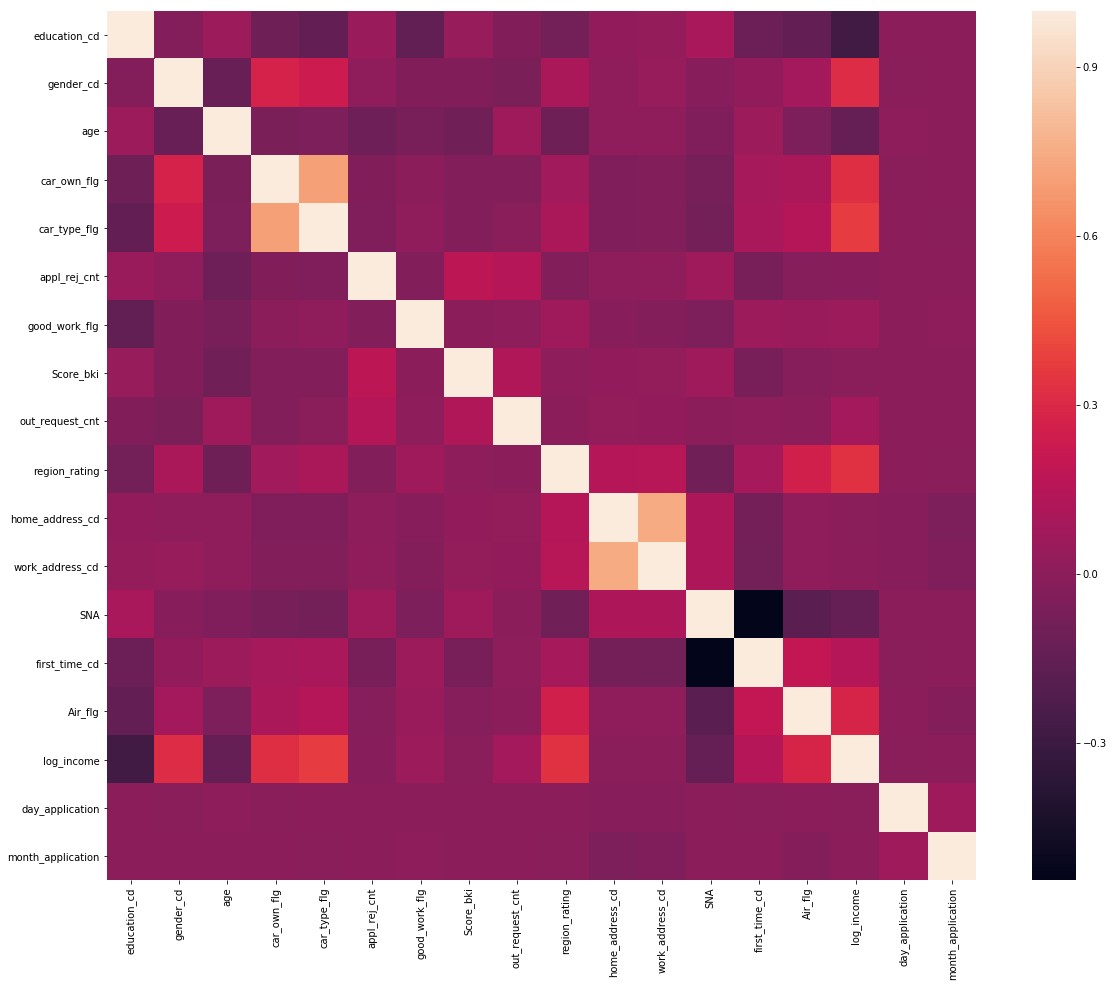

In [26]:
plt.figure(figsize=(20,16))
seaborn.heatmap(data.corr(), square=True)

Признаков достаточно мало и мы не будем выкидывать взаимозависимые, тем более в линейной модели используется регуляризация. Однако будем иметь ввиду, что признаки: наличие автомобиля и иномарки, а так же домашний и рабочий адрес сильно коррелируемы между собой

### 2. Разбивка и подготовка данных <a class='anchor' id='2'></a>
[в начало](#0)

In [27]:
# data.head()

In [29]:
X = data[:180816]
X_test = data[180816:]
y = label.default_flg.values
print('Train data:{}, Train labels:{}'.format(X.shape, label.default_flg.shape))
print ('Test data:{}'.format(X_test.shape))

Train data:(180816, 18), Train labels:(180816,)
Test data:(24480, 18)


In [30]:
'''Перемешивание выборки'''
X,y = shuffle(X,y)

Разобьем с перемешиванием обучающую выборку и целевые метки на обучение и валидацию:

In [31]:
1-70668/110148 # доля валидационной выборки (1-validate/train)

0.3584268438827759

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3584)
print('X_train:{}, y_train:{}'.format(X_train.shape, y_train.shape))
print('X_valid:{}, y_valid:{}'.format(X_valid.shape, y_valid.shape))

X_train:(116011, 18), y_train:(116011,)
X_valid:(64805, 18), y_valid:(64805,)


### 3. Создание конвеера и обучение моделей <a class='anchor' id='3'></a>
[в начало](#0)

In [33]:
# для бинарных признаков
binary_data_columns = ['gender_cd', 'car_own_flg', 'car_type_flg', 'good_work_flg', 'Air_flg']
binary_data_indices = np.array([(column in binary_data_columns) for column in X_train.columns], dtype = bool)

In [34]:
# для целых признаков 
numeric_data_columns = ['education_cd','day_application','month_application','appl_rej_cnt','out_request_cnt',
                        'region_rating','home_address_cd','work_address_cd','SNA','first_time_cd'] 
numeric_data_indices = np.array([(column in numeric_data_columns) for column in X_train.columns], dtype = bool)

In [35]:
# для вещественных признаков        
float_data_columns = ['Score_bki','log_income','log_age'] 
float_data_indices = np.array([(column in float_data_columns) for column in X_train.columns], dtype = bool)

**Задание моделей**

In [36]:
model_1 = LogisticRegression(random_state = 0, class_weight='balanced')
model_2 = LinearSVC(random_state = 0, class_weight='balanced')
model_3 = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=100)
model_4 = GradientBoostingClassifier(random_state=0, n_estimators=100)

**Построение конвеера**

In [37]:
'''функция конвеер'''
def PipModel(model):
    pip = pipeline.Pipeline([
        # шаг 1: рзбивка на виды и предобработка
        ('feature_processing', pipeline.FeatureUnion([
            # шаг 1.1: вещественные признаки (выделение)
            ('binary_variables_processing', FunctionTransformer(lambda d: d[:, binary_data_indices])),  
            # шаг 1.2: целые признаки (выделение)
            ('numeric_variables_processing', pipeline.Pipeline([
                    ('selecting', FunctionTransformer(lambda d: d[:, numeric_data_indices])), 
                    ('scaling', StandardScaler(with_mean = 0))
                    #('scaling', MinMaxScaler())
            ])),
            # шаг 1.3: вещественные признаки (выделение и стандартизация)
            ('float_variables_processing', pipeline.Pipeline([
                    ('selecting', FunctionTransformer(lambda d: d[:, float_data_indices])),
                    ('scaling', StandardScaler(with_mean = 0))
                    #('scaling', MinMaxScaler())
            ]))
        ])),
        # шаг 2: обучение модели
        ('model_fitting', model)
    ])
    return pip

**Модель логистической регрессии:**

In [38]:
%%time
cv_1 = cross_val_score(PipModel(model_1), X, y, scoring='roc_auc', cv=5)

Wall time: 12.9 s


In [39]:
print('mean: {:.5f}, std: {:.5f}'.format(cv_1.mean(), cv_1.std()))

mean: 0.72360, std: 0.00537


**Модель линейного SVM:**

In [255]:
%%time
cv_2 = cross_val_score(PipModel(model_2), X, y, scoring='roc_auc', cv=5)

Wall time: 6min 20s


In [262]:
print('mean: {:.5f}, std: {:.5f}'.format(cv_2.mean(), cv_2.std()))

mean: 0.71895, std: 0.00288


**Модель cлучайного леса:**

In [265]:
%%time
cv_3 = cross_val_score(model_3, X, y, scoring='roc_auc', cv=5)

Wall time: 4min 29s


In [267]:
print('mean: {:.3f}, std: {:.3f}'.format(cv_3.mean(), cv_3.std()))

mean: 0.705, std: 0.004


**Модель градиентного бустинга:**

In [312]:
%%time
cv_4 = cross_val_score(model_4, X, y, scoring='roc_auc', cv=5)

Wall time: 3min 9s


In [313]:
print('mean: {:.3f}, std: {:.3f}'.format(cv_4.mean(), cv_4.std()))

mean: 0.735, std: 0.002


### 4. Добавление полиномов и подбор параметров по сетке<a class='anchor' id='4'></a>
[в начало](#0)

In [40]:
from sklearn.preprocessing import PolynomialFeatures

Число сочетаний полиномов второй степени за исключением квадратов составляет 153

Плюс 18 исходных признаков

In [41]:
pip_log = pipeline.Pipeline([('scaling', StandardScaler(with_mean = 0)),
                             ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                             ('model', model_1)])

In [316]:
%%time
cv_p1 = cross_val_score(pip_log, X, y, scoring='roc_auc', cv=5)

Wall time: 21min 52s


In [317]:
print('mean: {:.5f}, std: {:.5f}'.format(cv_p1.mean(), cv_p1.std()))

mean: 0.72804, std: 0.00092


**Подбор параметров по сетке для Лог регрессии с полиномами**

In [42]:
param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [43]:
grid_log = GridSearchCV(pip_log, param_grid, scoring='roc_auc', cv=5)

In [44]:
%%time
grid_log.fit(X,y)

Wall time: 1h 52min 10s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=0, with_std=True)), ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)), ('model', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [45]:
grid_log.grid_scores_

C:\Users\Dima\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.72774, std: 0.00562, params: {'model__C': 0.001},
 mean: 0.72797, std: 0.00568, params: {'model__C': 0.01},
 mean: 0.72806, std: 0.00582, params: {'model__C': 0.1},
 mean: 0.72812, std: 0.00590, params: {'model__C': 1},
 mean: 0.72815, std: 0.00592, params: {'model__C': 10},
 mean: 0.72814, std: 0.00593, params: {'model__C': 100}]

Качетсво улучшилось, но все же уступает градиентному бистингу

**Подбор параметров по сетке для Градинтного бустинга**

In [51]:
param_grid = {'learning_rate': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]}

In [52]:
model_4 = GradientBoostingClassifier(random_state=0, n_estimators=500)
grid = GridSearchCV(model_4, param_grid, scoring='roc_auc', cv=5)

In [53]:
%%time
grid.fit(X,y)

Wall time: 3h 9min 50s


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [54]:
grid.grid_scores_

C:\Users\Dima\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.70652, std: 0.00405, params: {'learning_rate': 0.0025},
 mean: 0.71755, std: 0.00472, params: {'learning_rate': 0.005},
 mean: 0.72415, std: 0.00494, params: {'learning_rate': 0.0075},
 mean: 0.72806, std: 0.00510, params: {'learning_rate': 0.01},
 mean: 0.73555, std: 0.00495, params: {'learning_rate': 0.025},
 mean: 0.73676, std: 0.00490, params: {'learning_rate': 0.05},
 mean: 0.73655, std: 0.00505, params: {'learning_rate': 0.075},
 mean: 0.73640, std: 0.00517, params: {'learning_rate': 0.1},
 mean: 0.73304, std: 0.00494, params: {'learning_rate': 0.25},
 mean: 0.72387, std: 0.00473, params: {'learning_rate': 0.5},
 mean: 0.71155, std: 0.00356, params: {'learning_rate': 0.75},
 mean: 0.70148, std: 0.00423, params: {'learning_rate': 1}]

In [55]:
# лучшие параметры
grid.best_params_

{'learning_rate': 0.05}

### 5. Сравнение ROC кривых<a class='anchor' id='5'></a>
[в начало](#0)

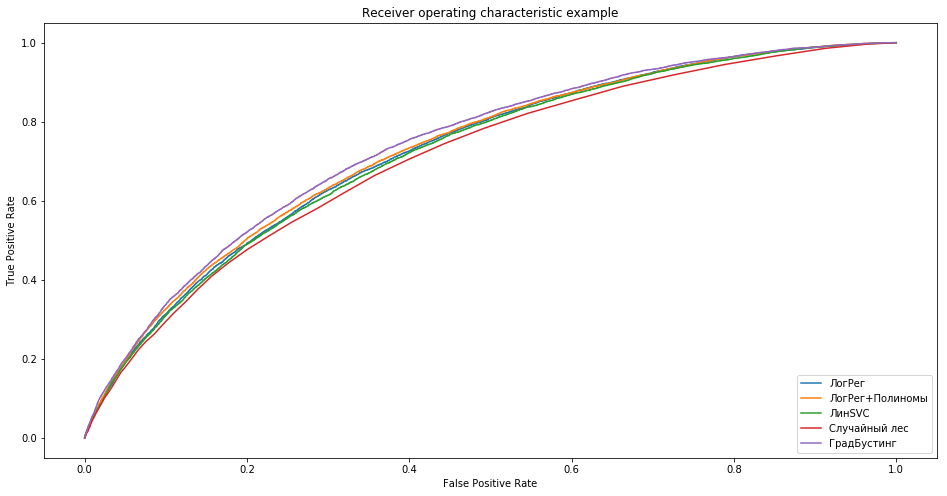

In [327]:
models = [PipModel(model_1), pip, PipModel(model_2), model_3, model_4]
str_models = ['ЛогРег', 'ЛогРег+Полиномы', 'ЛинSVC', 'Случайный лес', 'ГрадБустинг']

plt.figure(figsize=(16, 8)) 
for model, str_model in zip(models,str_models):
    model.fit(X_train, y_train)
    if (str_model in ['ЛинSVC']):
        pred_scr = model.decision_function(X_valid)
    else:
        pred_scr = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, pred_scr)
    plt.plot(fpr, tpr, label=str_model)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

**В качестве итоговой модели берем Градиентный бутсинг с лучшим параметром по стеке**

### 6. Получение прогнозов на тесте <a class='anchor' id='6'></a>
[в начало](#0)

Обучим модель на тестовых данных и загрузим результаты в kaggle

In [56]:
Model = GradientBoostingClassifier(random_state=0, learning_rate=0.05, n_estimators=500)

In [57]:
%%time
Model.fit(X,y)

Wall time: 4min 1s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [58]:
test_pd = Model.decision_function(X_test)

In [59]:
test_pd.shape

(24480,)

In [60]:
data = pd.read_csv('application_info.csv', index_col='id')
label = pd.read_csv('default_flg.csv') # подргузим id целевыt метки

test_index  = data[data.sample_cd =='test'].sample_cd.index

In [61]:
test_index.shape

(24480,)

In [62]:
# test_pd = pd.DataFrame(test_pd, columns=['score'], index=test_index)
test_pd2 = pd.DataFrame(test_pd, columns=['score'], index=test_index)
test_pd2.to_csv('My_Submission_GB.csv')
print(test_pd2.shape)
test_pd2.head(2)

(24480, 1)


,score
id,
180817,-2.379717
180818,-1.804977


### [в начало](#0)